## Import libraries

In [3]:
# run this to install these packages
# pip install -r requirements.txt 

# Supress Warnings 
import warnings
warnings.filterwarnings('ignore')

# Data Manipulation
import os # for file management
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd
import rioxarray as rxr
import rasterio
from rasterio.windows import Window
from rasterio.mask import mask
from matplotlib.cm import RdYlGn,jet,RdBu
from pyproj import Proj, Transformer, CRS
import seaborn as sns
from shapely.geometry import Point
import pystac_client
import planetary_computer 
from odc.stac import stac_load
from tqdm import tqdm

# Machine Learning
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor

As the notebook is stored in `notebooks` directory, we need to change the working directory to the root to make it easier to import the modules or datasets

In [2]:
# Get the absolute path of the project's root directory
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
# Change working directory
os.chdir(project_root)
# Check the current working directory
os.getcwd()

'/Users/masonphung/Desktop/data science/data_projects/challenge_ey2025'

## II. Data processing
### A. Import sentinel-2 and Landsat data

Let's define important parameters 

In [18]:
# Define the bounding box for the entire data region using (Latitude, Longitude)
# This is the region of New York City that contains our temperature dataset
lower_left = (40.75, -74.01)
upper_right = (40.88, -73.86)

# Calculate the bounds for doing an archive data search
# bounds = (min_lon, min_lat, max_lon, max_lat)
bounds = (lower_left[1], lower_left[0], upper_right[1], upper_right[0])

# Define the time window
time_window = "2021-06-01/2021-09-01"

Get the data from source

In [19]:
def look_for_data(bounds, collections, query, datetime):
    stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
    
    # Search for "lt- low cloud" with cloud cover <30%
    search = stac.search(
        bbox=bounds, 
        datetime=datetime,
        collections=collections,
        query=query,
    )
    
    # Get the number of items
    items = list(search.get_items())
    print('Number of scenes that touch our region:',len(items))
    
    signed_items = [planetary_computer.sign(item).to_dict() for item in items]
    return items, signed_items

def get_data(bounds, collections, query, datetime, bands, resolution):
    items, signed_items = look_for_data(
        bounds=bounds,
        collections=collections,
        query=query,
        datetime=datetime
    )
    data = stac_load(
        items,
        bands=bands,
        crs="EPSG:4326", # Latitude-Longitude
        resolution=resolution,
        chunks={"x": 2048, "y": 2048},
        dtype="uint16",
        patch_url=planetary_computer.sign,
        bbox=bounds
    )
    print("Data loaded!")
    return data

raw_sen_data = get_data(
        bounds=bounds,
        collections=["sentinel-2-l2a"],
        query={"eo:cloud_cover": {"lt": 30}},
        datetime=time_window,
        bands=["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"],
        resolution=10/111320.0,
)

raw_land_data = get_data(
        bounds=bounds,
        collections=["landsat-c2-l2"],
        query={"eo:cloud_cover": {"lt": 50},"platform": {"in": ["landsat-8"]}},
        datetime=time_window,  
        bands=["lwir11"],
        resolution=30/111320.0,
)

Number of scenes that touch our region: 10
Data loaded!
Number of scenes that touch our region: 8
Data loaded!


In [20]:
display(raw_sen_data)

<xarray.Dataset> Size: 532MB
Dimensions:      (latitude: 1448, longitude: 1671, time: 10)
Coordinates:
  * latitude     (latitude) float64 12kB 40.88 40.88 40.88 ... 40.75 40.75 40.75
  * longitude    (longitude) float64 13kB -74.01 -74.01 -74.01 ... -73.86 -73.86
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 80B 2021-06-06T15:38:09.024000 ... 202...
Data variables:
    B01          (time, latitude, longitude) uint16 48MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B02          (time, latitude, longitude) uint16 48MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B03          (time, latitude, longitude) uint16 48MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B04          (time, latitude, longitude) uint16 48MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B05          (time, latitude, longitude) uint16 48MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B06          (time, latitude, longitude) uint16 48MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B07          (time, latitude, longitude) uint16 48MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B08          (time, latitude, longitude) uint16 48MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B8A          (time, latitude, longitude) uint16 48MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B11          (time, latitude, longitude) uint16 48MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B12          (time, latitude, longitude) uint16 48MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>

In [14]:
# Take
sen_data = raw_sen_data.median(dim="time").compute()

# Scale Factors for the Surface Temperature band
scale = 0.00341802 
offset = 149.0 
kelvin_celsius = 273.15 # convert from Kelvin to Celsius
land_data = raw_land_data.astype(float) * scale + offset - kelvin_celsius

In [25]:
def save_data(data, filename, bands, scene=None):
    if "time" in data.dims and scene is not None:
        data_slice = data.isel(time=scene)
    else:
        data_slice = data  # No time dimension, use full dataset
    # Calculate the dimensions of the file
    height = data_slice.dims["latitude"]
    width = data_slice.dims["longitude"]

    # Define the Coordinate Refeerence System (CRS) to be common Lat-Lon coordinates
    # Define the tranformation using our bounding box so the Lat-Lon information is written to the GeoTIFF
    gt = rasterio.transform.from_bounds(lower_left[1], lower_left[0], upper_right[1], upper_right[0], width,height)
    data_slice.rio.write_crs("epsg:4326", inplace=True)
    data_slice.rio.write_transform(transform=gt, inplace=True);

    # Create the GeoTIFF output file using the defined parameters
    # Select 6 bands
    with rasterio.open(filename,'w',driver='GTiff',width=width,height=height,
                    crs='epsg:4326',transform=gt,count=len(bands),compress='lzw',dtype='float64') as dst:
        for i, band in enumerate(bands, start=1):
            dst.write(getattr(data_slice, band), i)
        dst.close()
    return print("Operation completed!")

In [26]:
save_data(
    data=sen_data, 
    filename="data/interim/Sen2.tiff",
    bands=["B01", "B02", "B03", "B04", "B06", "B08", "B11", "B12"])
save_data(
    data=land_data, 
    filename="data/interim/Landsat_LST.tiff", 
    scene=2, 
    bands=["lwir11"])

Operation completed!
Operation completed!


### B. Data manipulation for model training

<h4 style="color:rgb(255, 255, 0)">1. Map satelitte data with the coordinates in the training file</h4>

In [ ]:
def extract_band_values(sentinel_tiff, landsat_tiff, ground_df_path, sentinel_bands, landsat_bands, buffer_sizes):
    """
    Extract Sentinel-2 & Landsat band values at given locations, with optional focal buffers.
    
    Parameters:
    - sentinel_tiff (str): Path to Sentinel-2 GeoTIFF.
    - landsat_tiff (str): Path to Landsat GeoTIFF.
    - ground_df_path (str): Path to CSV containing Latitude, Longitude.
    - sentinel_bands (list): List of Sentinel-2 bands to extract (e.g., ["B02", "B03"]).
    - landsat_bands (list): List of Landsat bands to extract (e.g., ["lwir11"]).
    - buffer_sizes (list): List of buffer sizes in meters (e.g., [0, 50, 100]).

    Returns:
    - pd.DataFrame: Dataframe with extracted band values (with buffer names if applicable).
    """

    # Band-to-index mapping based on how they were saved
    sentinel_band_map = {
        "B01": 1, "B02": 2, "B03": 3, "B04": 4, 
        "B06": 5, "B08": 6, "B11": 7, "B12": 8
    }
    landsat_band_map = {"lwir11": 1}  # Landsat has only one band

    # Read ground data
    ground_df = pd.read_csv(ground_df_path)
    geometry = [Point(xy) for xy in zip(ground_df["Longitude"], ground_df["Latitude"])]
    ground_gdf = gpd.GeoDataFrame(ground_df, geometry=geometry, crs="EPSG:4326")

    # Function to extract value at a point with optional buffer
    def extract_value(src, band_index, x, y, buffer):
        row, col = src.index(x, y)
        if buffer == 0:
            return src.read(band_index)[row, col]
        else:
            res = src.res[0]  # Assume square pixels, get resolution in degrees
            buffer_pixels = int(buffer / (res * 111320))  # Convert meters to pixel units
            window = Window(col - buffer_pixels, row - buffer_pixels, 2 * buffer_pixels + 1, 2 * buffer_pixels + 1)
            data = src.read(band_index, window=window)
            return np.nanmean(data)  # Return mean value within buffer

    # Extract values
    extracted_data = []

    for _, row in ground_gdf.iterrows():
        x, y = row["Longitude"], row["Latitude"]
        extracted_row = {}

        with rasterio.open(sentinel_tiff) as sen_src, rasterio.open(landsat_tiff) as land_src:
            for band in sentinel_bands:
                band_index = sentinel_band_map[band]
                for buffer in buffer_sizes:
                    feature_name = f"{band}" if buffer == 0 else f"{band}_buffer{buffer}"
                    extracted_row[feature_name] = extract_value(sen_src, band_index, x, y, buffer)

            for band in landsat_bands:
                band_index = landsat_band_map[band]
                for buffer in buffer_sizes:
                    feature_name = f"{band}" if buffer == 0 else f"{band}_buffer{buffer}"
                    extracted_row[feature_name] = extract_value(land_src, band_index, x, y, buffer)

        extracted_data.append(extracted_row)

    return pd.DataFrame(extracted_data)

In [97]:
sentinel_bands = ["B01", "B02", "B03", "B04", "B06", "B08", "B11", "B12"]
landsat_bands = ["lwir11"]
buffer_sizes = [0, 50, 100, 200]

extracted_df = extract_band_values(
    sentinel_tiff="data/interim/Sen2.tiff",
    landsat_tiff="data/interim/Landsat_LST.tiff",
    ground_df_path="data/interim/ground_df.csv",
    sentinel_bands=sentinel_bands,
    landsat_bands=landsat_bands,
    buffer_sizes=buffer_sizes
)

In [ ]:
# Only run when needed to keep a version of the data for reproducibility
# extracted_df.to_csv("data/processed/focal_buffered_bands.csv", index=False)
extracted_df

,B01,B01_buffer50,B01_buffer100,B01_buffer200,B02,B02_buffer50,B02_buffer100,B02_buffer200,B03,B03_buffer50,...,B11_buffer100,B11_buffer200,B12,B12_buffer50,B12_buffer100,B12_buffer200,lwir11,lwir11_buffer50,lwir11_buffer100,lwir11_buffer200
0,841.5,1044.665289,1064.115646,1065.712374,1053.0,1082.376033,1207.403628,1183.302796,1155.0,1230.677686,...,2166.871882,2264.903926,1495.5,1691.326446,1858.497732,1915.300119,38.393941,38.256081,37.882354,37.101303
1,841.5,1044.665289,1064.115646,1065.712374,1053.0,1082.376033,1207.403628,1183.302796,1155.0,1230.677686,...,2166.871882,2264.903926,1495.5,1691.326446,1858.497732,1915.300119,38.393941,38.256081,37.882354,37.101303
2,841.5,1006.185950,1052.119048,1047.194230,646.0,1033.214876,1192.810658,1171.381023,823.0,1178.148760,...,2139.797052,2268.478882,1135.0,1559.549587,1815.963719,1908.776919,37.785534,37.647294,37.417922,36.775175
3,841.5,1014.256198,1063.826531,1050.802201,625.0,1050.859504,1221.667800,1171.131767,766.0,1198.326446,...,2155.858277,2274.820642,1135.0,1529.979339,1826.418367,1915.884890,37.785534,37.647294,37.417922,36.775175
4,841.5,1022.326446,1075.534014,1052.647531,659.5,1045.623967,1255.403628,1169.778703,763.0,1190.859504,...,2174.774376,2281.140095,1207.5,1520.892562,1839.721088,1921.883105,37.358281,37.297516,37.309522,36.789737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11224,462.5,427.636364,441.196145,441.925937,491.0,488.330579,509.202948,496.944081,725.5,677.764463,...,2220.272109,2191.051457,1072.5,1064.599174,1198.469388,1205.989590,30.293234,30.357796,30.321624,30.403743
11225,462.5,439.950413,444.214286,440.834325,506.5,516.504132,505.111111,494.835217,741.5,706.359504,...,2194.482993,2156.671029,1072.5,1092.640496,1179.698413,1185.059786,30.293234,30.357796,30.321624,30.403743
11226,462.5,439.950413,444.214286,440.834325,506.5,516.504132,505.111111,494.835217,741.5,706.359504,...,2194.482993,2156.671029,1072.5,1092.640496,1179.698413,1185.059786,30.440209,30.461476,30.253682,30.239617
11227,462.5,439.950413,444.214286,440.834325,506.5,516.504132,505.111111,494.835217,741.5,706.359504,...,2194.482993,2156.671029,1072.5,1092.640496,1179.698413,1185.059786,30.440209,30.461476,30.253682,30.239617


In [ ]:
def calc_band_indices(data):
    """
    Calculate the following indices from the satellite data:
    Parameters:
    data (DataFrame): The satellite data
    Returns:
    data (DataFrame): The satellite data with the indices columns
    """
    # Define the indices calculations
    indices = {}
    for each in buffer_sizes:
        if each == 0:
            print("Calculating combination indices without buffer...")
            indices.update(
                {
                    "NDVI": (data["B08"] - data["B04"]) / (data["B08"] + data["B04"]),
                    "NDBI": (data["B11"].astype("float64") - data["B08"].astype("float64")) / (data["B11"].astype("float64") + data["B08"].astype("float64")),
                    "NDWI": (data["B03"] - data["B08"]) / (data["B03"] + data["B08"]),
                    "EVI": 2.5 * (data["B08"] - data["B04"]) / (data["B08"] + 6 * data["B04"] - 7.5 * data["B02"] + 1),
                    "SAVI": ((data["B08"] - data["B04"]) / (data["B08"] + data["B04"] + 0.5)) * 1.5,
                    "NBAI": ((data["B11"] + data["B12"]) - data["B08"]) / ((data["B11"] + data["B12"]) + data["B08"])
                }
            )
        else:
            print(f"Calculating combination indices with buffer size of {each}m...")
            indices.update(
                {
                    f"NDVI_buffer{each}": (data[f"B08_buffer{each}"] - data[f"B04_buffer{each}"]) / (data[f"B08_buffer{each}"] + data[f"B04_buffer{each}"]),
                    f"NDBI_buffer{each}": (data[f"B11_buffer{each}"] - data[f"B08_buffer{each}"]) / (data[f"B11_buffer{each}"] + data[f"B08_buffer{each}"]),
                    f"NDWI_buffer{each}": (data[f"B03_buffer{each}"] - data[f"B08_buffer{each}"]) / (data[f"B03_buffer{each}"] + data[f"B08_buffer{each}"]),
                    f"EVI_buffer{each}": 2.5 * (data[f"B08_buffer{each}"] - data[f"B04_buffer{each}"]) / (data[f"B08_buffer{each}"] + 6 * data[f"B04_buffer{each}"] - 7.5 * data[f"B02_buffer{each}"] + 1),
                    f"SAVI_buffer{each}": ((data[f"B08_buffer{each}"] - data[f"B04_buffer{each}"]) / (data[f"B08_buffer{each}"] + data[f"B04_buffer{each}"] + 0.5)) * 1.5,
                    f"NBAI_buffer{each}": ((data[f"B11_buffer{each}"] + data[f"B12_buffer{each}"]) - data[f"B08_buffer{each}"]) / ((data[f"B11_buffer{each}"] + data[f"B12_buffer{each}"]) + data[f"B08_buffer{each}"])
                }
            )

    # Compute and clean each index dynamically
    for index_name, index_value in indices.items():
        data[index_name] = index_value.replace([np.inf, -np.inf], np.nan).astype("float64")
    return data

In [121]:
sat_data = calc_band_indices(extracted_df)
sat_data

,B01,B01_buffer50,B01_buffer100,B01_buffer200,B02,B02_buffer50,B02_buffer100,B02_buffer200,B03,B03_buffer50,...,NDWI_buffer100,EVI_buffer100,SAVI_buffer100,NBAI_buffer100,NDVI_buffer200,NDBI_buffer200,NDWI_buffer200,EVI_buffer200,SAVI_buffer200,NBAI_buffer200
0,841.5,1044.665289,1064.115646,1065.712374,1053.0,1082.376033,1207.403628,1183.302796,1155.0,1230.677686,...,-0.208236,0.872690,0.263100,0.318721,0.246986,-0.011559,-0.267923,1.246012,0.370429,0.286596
1,841.5,1044.665289,1064.115646,1065.712374,1053.0,1082.376033,1207.403628,1183.302796,1155.0,1230.677686,...,-0.208236,0.872690,0.263100,0.318721,0.246986,-0.011559,-0.267923,1.246012,0.370429,0.286596
2,841.5,1006.185950,1052.119048,1047.194230,646.0,1033.214876,1192.810658,1171.381023,823.0,1178.148760,...,-0.214849,0.913968,0.273674,0.311139,0.256528,-0.015830,-0.276269,1.278452,0.384741,0.281621
3,841.5,1014.256198,1063.826531,1050.802201,625.0,1050.859504,1221.667800,1171.131767,766.0,1198.326446,...,-0.207532,0.897117,0.262742,0.311298,0.256700,-0.014314,-0.276182,1.281384,0.384998,0.283210
4,841.5,1022.326446,1075.534014,1052.647531,659.5,1045.623967,1255.403628,1169.778703,763.0,1190.859504,...,-0.200667,0.893249,0.253343,0.310472,0.257134,-0.012600,-0.276306,1.285391,0.385649,0.284860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11224,462.5,427.636364,441.196145,441.925937,491.0,488.330579,509.202948,496.944081,725.5,677.764463,...,-0.672699,2.394715,1.106712,-0.046084,0.730705,-0.254217,-0.668399,2.288639,1.095929,-0.040632
11225,462.5,439.950413,444.214286,440.834325,506.5,516.504132,505.111111,494.835217,741.5,706.359504,...,-0.675145,2.454881,1.113664,-0.048486,0.731509,-0.255697,-0.668127,2.319626,1.097133,-0.042512
11226,462.5,439.950413,444.214286,440.834325,506.5,516.504132,505.111111,494.835217,741.5,706.359504,...,-0.675145,2.454881,1.113664,-0.048486,0.731509,-0.255697,-0.668127,2.319626,1.097133,-0.042512
11227,462.5,439.950413,444.214286,440.834325,506.5,516.504132,505.111111,494.835217,741.5,706.359504,...,-0.675145,2.454881,1.113664,-0.048486,0.731509,-0.255697,-0.668127,2.319626,1.097133,-0.042512


Load ground data and combine with the sentinel-2 dataset

In [126]:
# Load ground dataset
ground_df = pd.read_csv("data/interim/ground_df.csv")
# Simply use `pd.concat` as we've already get the data based on each lon & lat of ground_df
satground_df = pd.concat([ground_df,sat_data], axis=1)
satground_df

,Longitude,Latitude,datetime,UHI Index,building_coverage,building_count,B01,B01_buffer50,B01_buffer100,B01_buffer200,...,NDWI_buffer100,EVI_buffer100,SAVI_buffer100,NBAI_buffer100,NDVI_buffer200,NDBI_buffer200,NDWI_buffer200,EVI_buffer200,SAVI_buffer200,NBAI_buffer200
0,-73.909167,40.813107,24-07-2021 15:53,1.030289,5.773461e-06,44,841.5,1044.665289,1064.115646,1065.712374,...,-0.208236,0.872690,0.263100,0.318721,0.246986,-0.011559,-0.267923,1.246012,0.370429,0.286596
1,-73.909187,40.813045,24-07-2021 15:53,1.030289,5.773461e-06,44,841.5,1044.665289,1064.115646,1065.712374,...,-0.208236,0.872690,0.263100,0.318721,0.246986,-0.011559,-0.267923,1.246012,0.370429,0.286596
2,-73.909215,40.812978,24-07-2021 15:53,1.023798,5.773461e-06,44,841.5,1006.185950,1052.119048,1047.194230,...,-0.214849,0.913968,0.273674,0.311139,0.256528,-0.015830,-0.276269,1.278452,0.384741,0.281621
3,-73.909242,40.812908,24-07-2021 15:53,1.023798,5.773461e-06,44,841.5,1014.256198,1063.826531,1050.802201,...,-0.207532,0.897117,0.262742,0.311298,0.256700,-0.014314,-0.276182,1.281384,0.384998,0.283210
4,-73.909257,40.812845,24-07-2021 15:53,1.021634,5.773461e-06,44,841.5,1022.326446,1075.534014,1052.647531,...,-0.200667,0.893249,0.253343,0.310472,0.257134,-0.012600,-0.276306,1.285391,0.385649,0.284860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11224,-73.957050,40.790333,24-07-2021 15:57,0.972470,8.698000e-07,5,462.5,427.636364,441.196145,441.925937,...,-0.672699,2.394715,1.106712,-0.046084,0.730705,-0.254217,-0.668399,2.288639,1.095929,-0.040632
11225,-73.957063,40.790308,24-07-2021 15:57,0.972470,8.698000e-07,5,462.5,439.950413,444.214286,440.834325,...,-0.675145,2.454881,1.113664,-0.048486,0.731509,-0.255697,-0.668127,2.319626,1.097133,-0.042512
11226,-73.957093,40.790270,24-07-2021 15:57,0.981124,8.698000e-07,5,462.5,439.950413,444.214286,440.834325,...,-0.675145,2.454881,1.113664,-0.048486,0.731509,-0.255697,-0.668127,2.319626,1.097133,-0.042512
11227,-73.957112,40.790253,24-07-2021 15:59,0.981245,8.698000e-07,5,462.5,439.950413,444.214286,440.834325,...,-0.675145,2.454881,1.113664,-0.048486,0.731509,-0.255697,-0.668127,2.319626,1.097133,-0.042512


*We now have `satground_data` - a combination of the ground UHI data and the sentinel-2 indices data*

<h4 style="color:rgb(255, 255, 0)">2. Map `NY_Mesonet_Weather` data with our `satground_data`</h4>

Load `New York Mesonet Weather` data then merge them together

In [127]:
# Ensure file path is correct
path = "data/raw/NY_Mesonet_Weather.xlsx"
bronx_weather = pd.read_excel(f"{path}", sheet_name="Bronx", engine="openpyxl")
manhattan_weather = pd.read_excel(f"{path}", sheet_name="Manhattan", engine="openpyxl")

In [128]:
# Define function to classify borough
def classify_location(lat, lon):
    if 40.70 <= lat <= 40.88 and -74.01 <= lon <= -73.90:
        return "Manhattan"
    elif 40.78 <= lat <= 40.91 and -73.93 <= lon <= -73.78:
        return "Bronx"
    else:
        return "Unknown"

# Apply function to dataset
satground_df['location'] = satground_df.apply(
    lambda row: classify_location(row['Latitude'], row['Longitude']), axis=1)

# Make a copy to merge weather data
satground_df2 = satground_df.copy()

satground_df2.head()

,Longitude,Latitude,datetime,UHI Index,building_coverage,building_count,B01,B01_buffer50,B01_buffer100,B01_buffer200,...,EVI_buffer100,SAVI_buffer100,NBAI_buffer100,NDVI_buffer200,NDBI_buffer200,NDWI_buffer200,EVI_buffer200,SAVI_buffer200,NBAI_buffer200,location
0,-73.909167,40.813107,24-07-2021 15:53,1.030289,0.000006,44,841.5,1044.665289,1064.115646,1065.712374,...,0.872690,0.263100,0.318721,0.246986,-0.011559,-0.267923,1.246012,0.370429,0.286596,Manhattan
1,-73.909187,40.813045,24-07-2021 15:53,1.030289,0.000006,44,841.5,1044.665289,1064.115646,1065.712374,...,0.872690,0.263100,0.318721,0.246986,-0.011559,-0.267923,1.246012,0.370429,0.286596,Manhattan
2,-73.909215,40.812978,24-07-2021 15:53,1.023798,0.000006,44,841.5,1006.185950,1052.119048,1047.194230,...,0.913968,0.273674,0.311139,0.256528,-0.015830,-0.276269,1.278452,0.384741,0.281621,Manhattan
3,-73.909242,40.812908,24-07-2021 15:53,1.023798,0.000006,44,841.5,1014.256198,1063.826531,1050.802201,...,0.897117,0.262742,0.311298,0.256700,-0.014314,-0.276182,1.281384,0.384998,0.283210,Manhattan
4,-73.909257,40.812845,24-07-2021 15:53,1.021634,0.000006,44,841.5,1022.326446,1075.534014,1052.647531,...,0.893249,0.253343,0.310472,0.257134,-0.012600,-0.276306,1.285391,0.385649,0.284860,Manhattan


Let's manipulate the `Mesonet weather data` then merge their data with our `satground` dataset

In [129]:
# Rename the column to 'datetime'
bronx_weather = bronx_weather.rename(columns={"Date / Time": "datetime"})
manhattan_weather = manhattan_weather.rename(columns={"Date / Time": "datetime"})

In [130]:
# Convert satground_df to datetime dtype
satground_df2['datetime'] = pd.to_datetime(satground_df2['datetime'], format='%d-%m-%Y %H:%M')
# Convert weather data to datetime dtype, remove timezone sign
bronx_weather['datetime'] = pd.to_datetime(bronx_weather['datetime']).dt.tz_localize(None)
manhattan_weather['datetime'] = pd.to_datetime(manhattan_weather['datetime']).dt.tz_localize(None)

# Add 'location' column to weather DataFrames
bronx_weather['location'] = 'Bronx'
manhattan_weather['location'] = 'Manhattan'

# Concatenate both weather datasets
weather_df = pd.concat([bronx_weather, manhattan_weather])

# Ensure all DataFrames are sorted by datetime
satground_df2 = satground_df2.sort_values('datetime')
weather_df = weather_df.sort_values('datetime')

# Merge using 'Datetime' and 'location'
uhi_data = pd.merge_asof(satground_df2, weather_df, on='datetime', by='location')

# Check the final DataFrame
uhi_data.head()

,Longitude,Latitude,datetime,UHI Index,building_coverage,building_count,B01,B01_buffer50,B01_buffer100,B01_buffer200,...,NDWI_buffer200,EVI_buffer200,SAVI_buffer200,NBAI_buffer200,location,Air Temp at Surface [degC],Relative Humidity [percent],Avg Wind Speed [m/s],Wind Direction [degrees],Solar Flux [W/m^2]
0,-73.977157,40.771555,2021-07-24 15:01:00,0.975234,4.248421e-07,7,485.0,490.549587,479.476190,489.140690,...,-0.619805,2.220861,1.001402,-0.002176,Manhattan,26.1,51.1,4.1,139,140
1,-73.910167,40.803775,2021-07-24 15:01:00,1.000718,2.952757e-06,20,1319.5,1358.479339,1382.456916,1499.378049,...,-0.114681,0.687472,0.131146,0.371783,Manhattan,26.1,51.1,4.1,139,140
2,-73.910268,40.803817,2021-07-24 15:01:00,1.000718,2.952757e-06,20,1319.5,1409.012397,1427.698413,1490.610351,...,-0.113780,0.688302,0.130126,0.370850,Manhattan,26.1,51.1,4.1,139,140
3,-73.978742,40.771675,2021-07-24 15:01:00,0.975234,1.083310e-05,22,469.0,505.966942,599.826531,705.143367,...,-0.446528,1.725307,0.673645,0.134767,Manhattan,26.1,51.1,4.1,139,140
4,-73.978453,40.771677,2021-07-24 15:01:00,0.970907,4.248421e-07,7,400.5,484.061983,552.826531,655.446163,...,-0.489247,1.884191,0.754492,0.103449,Manhattan,26.1,51.1,4.1,139,140


Drop duplicates

In [ ]:
# Remove duplicate rows from the DataFrame based on specified columns and keep the first occurrence
columns_to_check = uhi_data.drop(columns=['Longitude', 'Latitude', 'datetime', 'UHI Index']).columns
for col in columns_to_check:
    # Check if the value is a numpy array and has more than one dimension
    uhi_data[col] = uhi_data[col].apply(lambda x: tuple(x) if isinstance(x, np.ndarray) and x.ndim > 0 else x)

# Now remove duplicates
uhi_data = uhi_data.drop_duplicates(subset=columns_to_check, keep='first')
uhi_data

,Longitude,Latitude,datetime,UHI Index,building_coverage,building_count,B01,B01_buffer50,B01_buffer100,B01_buffer200,...,NDBI_buffer200,NDWI_buffer200,EVI_buffer200,SAVI_buffer200,NBAI_buffer200,Air Temp at Surface [degC],Relative Humidity [percent],Avg Wind Speed [m/s],Wind Direction [degrees],Solar Flux [W/m^2]
count,9490.000000,9490.000000,9490,9490.000000,9.490000e+03,9490.000000,9490.000000,9490.000000,9490.000000,9490.000000,...,9490.000000,9490.000000,9490.000000,9490.000000,9490.000000,9490.000000,9490.000000,9490.000000,9490.000000,9490.000000
mean,-73.933771,40.808573,2021-07-24 15:34:13.441517568,0.999903,8.103458e-06,42.302424,1196.366649,1198.493155,1197.318677,1184.557966,...,-0.007429,-0.227980,1.193295,0.315517,0.287464,26.885279,47.832792,2.978419,168.077871,462.748999
min,-73.994457,40.758792,2021-07-24 15:01:00,0.956122,2.370098e-08,1.000000,243.500000,346.008264,378.989796,405.222487,...,-0.301049,-0.691276,-22.050004,-0.023740,-0.098230,26.100000,40.200000,1.400000,91.000000,128.000000
25%,-73.955865,40.790613,2021-07-24 15:22:00,0.988697,5.875661e-06,28.000000,970.000000,1002.036157,1032.563209,1051.014500,...,-0.034975,-0.268079,0.849493,0.183926,0.258392,26.600000,46.700000,2.500000,154.000000,349.000000
50%,-73.932769,40.810394,2021-07-24 15:35:00,1.000358,8.173191e-06,39.000000,1184.000000,1191.456612,1202.529478,1206.619423,...,0.010827,-0.197686,1.130527,0.260501,0.311812,26.800000,47.600000,3.200000,163.000000,511.000000
75%,-73.909355,40.823515,2021-07-24 15:48:00,1.011056,1.038176e-05,56.000000,1420.500000,1402.529959,1386.387755,1346.271490,...,0.040072,-0.153226,1.459981,0.380287,0.344900,27.200000,49.700000,3.500000,196.000000,605.000000
max,-73.879458,40.859497,2021-07-24 15:59:00,1.046036,1.634728e-05,120.000000,2671.500000,2362.020661,2157.160998,1867.478584,...,0.191696,0.010243,4.156781,1.148126,0.485197,28.300000,51.100000,4.500000,209.000000,725.000000
std,0.028458,0.023046,NaN,0.016190,3.679657e-06,23.752252,364.225655,326.081096,297.910727,257.030625,...,0.075002,0.119653,0.584712,0.211031,0.092142,0.381346,2.093224,0.711411,26.702822,181.522027


<h4 style="color:rgb(255, 255, 0)">3. Correlation check</h4>

Text(0.5, 1.0, 'Correlation between the variables of the UHI dataset')

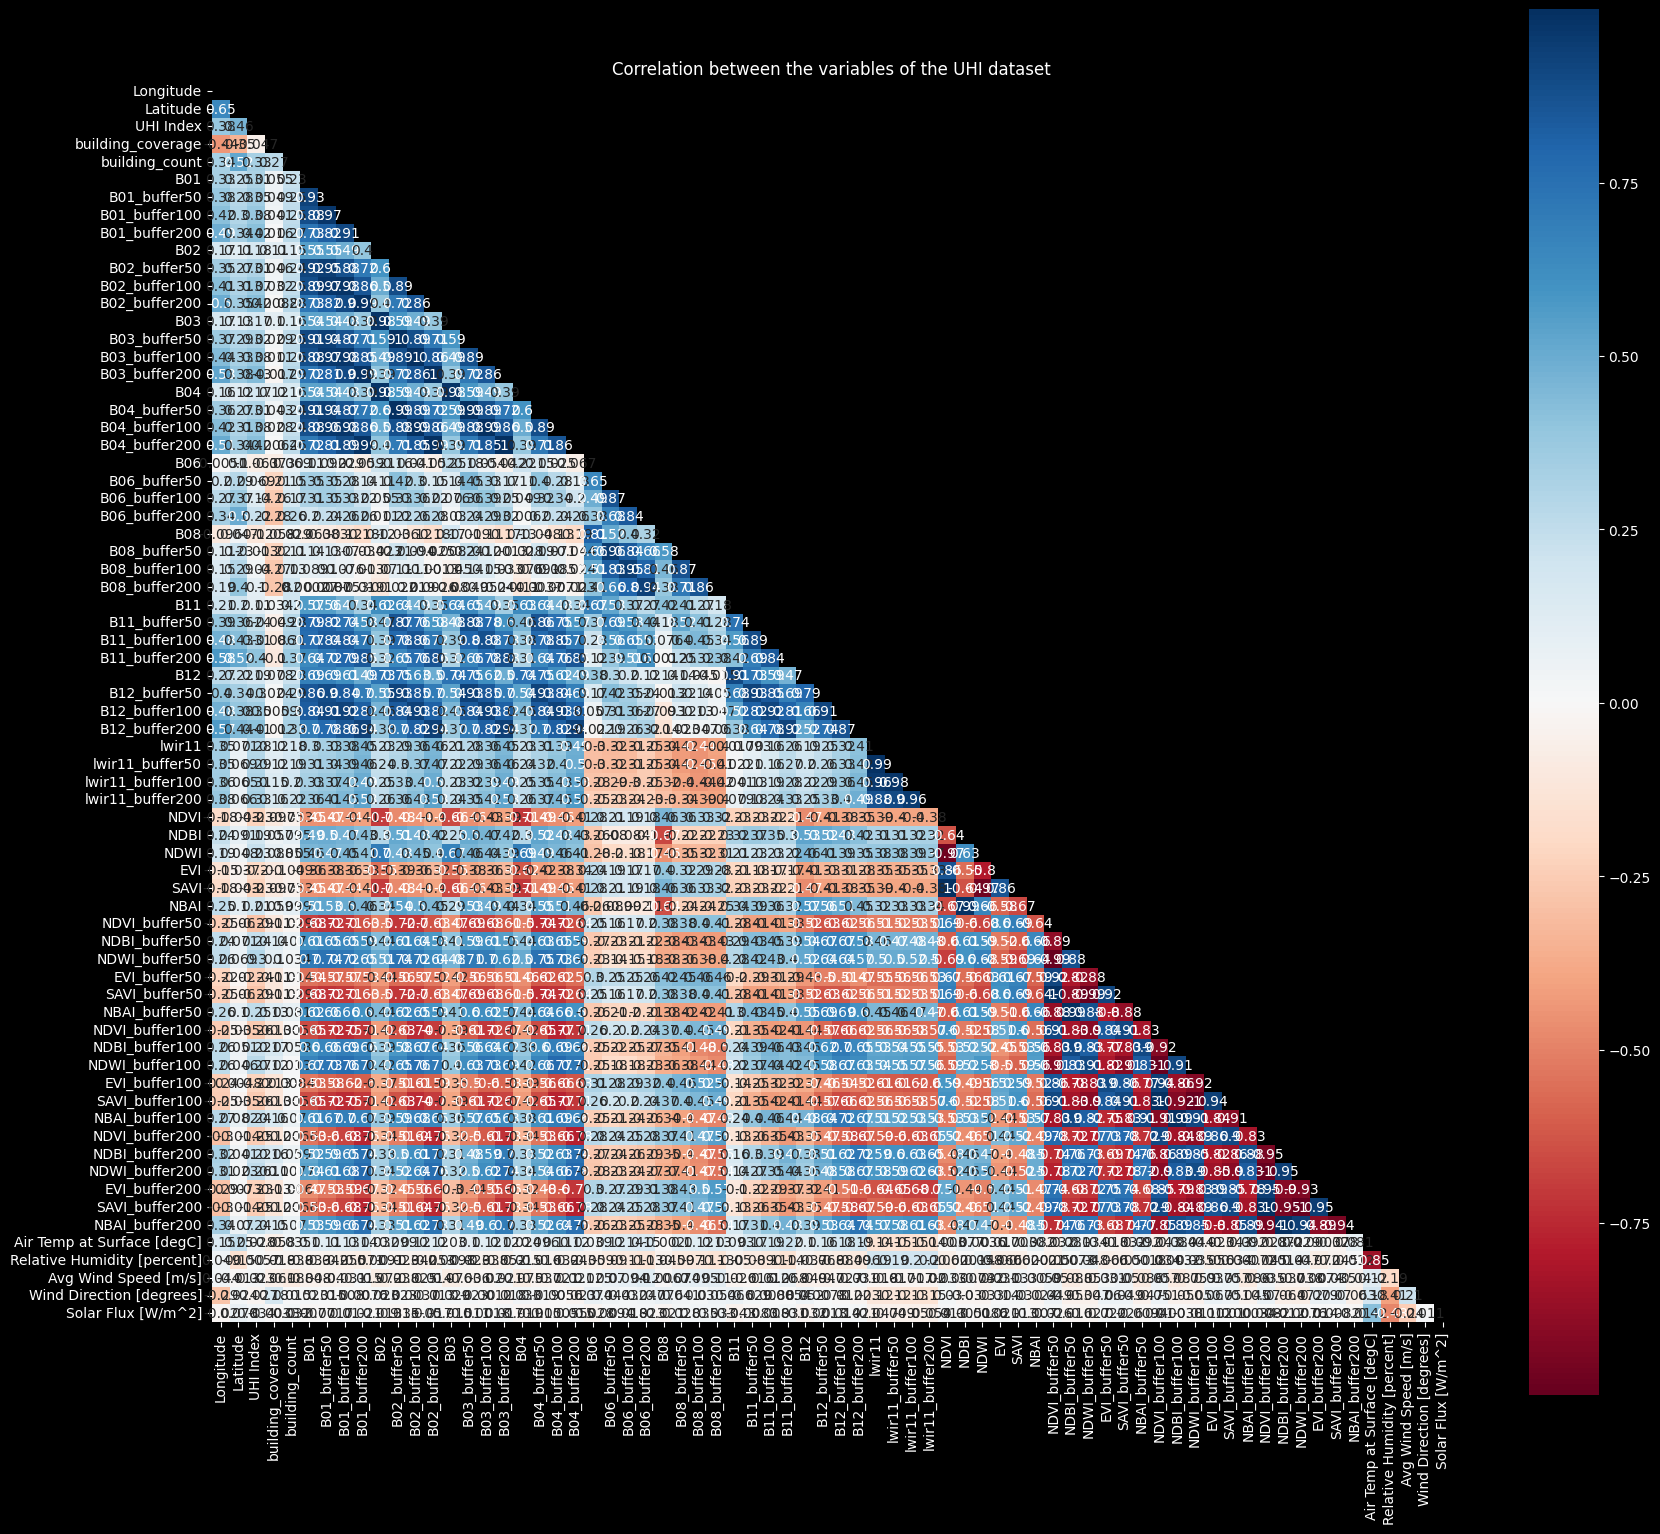

In [133]:
# Calculate correlation between all of the variables using `spearman` method
corr = uhi_data.drop(columns=['datetime', 'location']).corr(method = 'spearman')
corr

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
plt.style.use("dark_background")
plt.subplots
f, ax = plt.subplots(figsize=(20, 18))


# Visualize with a correlation matrix heatmap
sns.heatmap(
    corr,
    annot = True,
    mask = mask,
    center = 0,
    square = True,
    cmap = "RdBu",
    xticklabels = 'auto',
)

plt.title('Correlation between the variables of the UHI dataset',)

In [134]:
uhi_data.to_csv('data/processed/uhi_data.csv')

## Machine Learning

<h4 style="color:rgb(255, 255, 0)">1. Model training</h4>

- Choose the features and target variable by dropping the unnecessary columns and choosing the UHI index as the target variable.
- Split data with 70/30 ratio, then scale the data

In [135]:
# Retaining only the columns for B01, B06, NDVI, and UHI Index in the dataset.
train_data = uhi_data.drop(columns=[
    'Longitude', 'Latitude', 'datetime', 'location', 
    'Air Temp at Surface [degC]','Relative Humidity [percent]', 'Avg Wind Speed [m/s]','Wind Direction [degrees]', 'Solar Flux [W/m^2]'
    ])

# Split the data into features (X) and target (y), and then into training and testing sets
X = train_data.drop(columns=['UHI Index'])
y = train_data ['UHI Index']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42)

# Scale the training and test data using standardscaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

B1. Train XGB model without tuning

In [136]:
# 4. Initialize the final XGBoost model with the best hyperparameters
model = xgb.XGBRegressor()

# 5. Train the final XGBoost model
model.fit(X_train, y_train)

# 6. Predict on the validation set
y_pred_xgb_final = model.predict(X_train)

# 7. Evaluate performance of the final model
#print("MAE train (final XGBoost):", mean_absolute_error(Y_train, y_pred_xgb_final))
print("R² Score train (final XGBoost):", r2_score(y_train, y_pred_xgb_final))

# 8. Predict on the validation set
y_pred_xgb_final = model.predict(X_test)

# 9. Evaluate performance of the final model
#print("MAE (final XGBoost):", mean_absolute_error(Y_test, y_pred_xgb_final))
print("R² Score (final XGBoost):", r2_score(y_test, y_pred_xgb_final))

R² Score train (final XGBoost): 0.9898612495319092
R² Score (final XGBoost): 0.8990308626021798


B2. Train XGB model with GridSearchCV

In [137]:
# Define the parameter grid for Random Forest
param_grid_xgb = {
    'max_depth': [6, 9, 12],              # Best max_depth from tuning
    'subsample': [0.5, 0.75, 1],             # Best subsample from tuning
    'min_child_weight': [0, 1, 2, 3],        # Best min_child_weight from tuning
    'colsample_bytree': [0.5, 0.75, 1],      # Best colsample_bytree from tuning
    'learning_rate': [0.05, 0.1, 0.15, 0.2],        # Best learning_rate from tuning
    'n_estimators': [100, 300, 500],           # Keep the number of estimators 
}

# Initialize the Random Forest model
xgb_model = xgb.XGBRegressor(objective="reg:squarederror",random_state=42)

# Perform GridSearchCV with 5-fold cross-validation
grid_search_xgb = GridSearchCV(
    estimator=xgb_model, param_grid=param_grid_xgb, 
    cv=5, scoring='r2', n_jobs=-1, verbose=1
)

# Fit the model on the training data
grid_search_xgb.fit(X_train, y_train)

# Print the best parameters and the best score
print(f"Best Parameters: {grid_search_xgb.best_params_}")
print(f"Best Cross-Validation Score: {grid_search_xgb.best_score_}")

# Get the best model from grid search
best_xgb_model = grid_search_xgb.best_estimator_

# 6. Predict on the validation set
y_pred_xgb_final = best_xgb_model.predict(X_train)
# 7. Evaluate performance of the final model
print("R² Score on train set:", r2_score(y_train, y_pred_xgb_final))
# Make predictions with the best model on the test set
outsample_predictions_xgb = best_xgb_model.predict(X_test)
# 9. Evaluate performance of the final model
print("R² Score on test set:", r2_score(y_test, outsample_predictions_xgb))

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits
Best Parameters: {'colsample_bytree': 1, 'learning_rate': 0.05, 'max_depth': 12, 'min_child_weight': 3, 'n_estimators': 500, 'subsample': 0.75}
Best Cross-Validation Score: 0.91899933764014
R² Score on train set: 0.9991150466769042
R² Score on test set: 0.931178195435012


<h4 style="color:rgb(255, 255, 0)">2. Feature evaluation</h4>

              Feature  Importance
33      B12_buffer200    0.152752
1      building_count    0.117402
60     SAVI_buffer200    0.085474
0   building_coverage    0.079269
29      B11_buffer200    0.039435


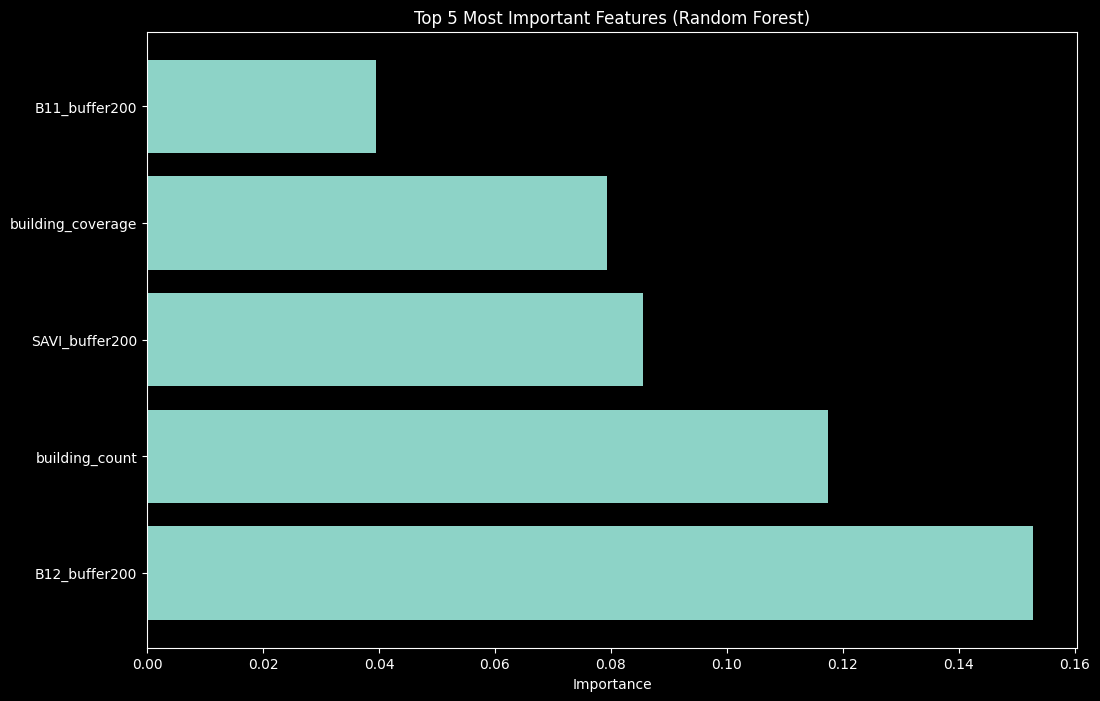

In [147]:
# Get feature importances
importances = best_xgb_model.feature_importances_

# Create a DataFrame to hold feature names and their corresponding importance
feature_importance = pd.DataFrame({
    'Feature': train_data.drop(columns=['UHI Index']).columns,  # Assuming train_data is your DataFrame
    'Importance': importances
})

# Sort the features by importance
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Display the most important features
print(feature_importance.head(5))  # Print top 5 important features

# Plot feature importance
plt.figure(figsize=(12, 8))
plt.barh(feature_importance['Feature'][:5], feature_importance['Importance'][:5])
plt.xlabel('Importance')
plt.title('Top 5 Most Important Features (Random Forest)')
plt.show()

Evaluate feature importance with SHAP

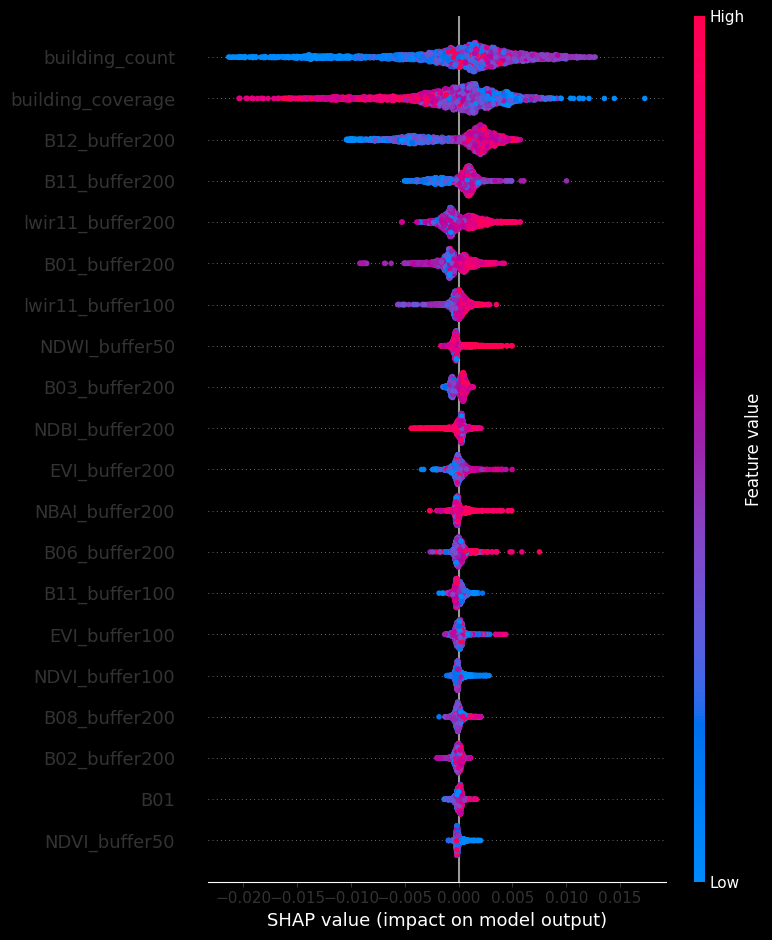

In [154]:
import shap

# Initialize SHAP explainer
explainer = shap.Explainer(best_xgb_model)
shap_values = explainer.shap_values(X_test)

# Summary plot (global feature importance)
shap.summary_plot(
    shap_values, 
    feature_names=X.columns,
    features = X_test
)

In [2]:
# Reading the coordinates for the submission
test_file = pd.read_csv('data/test/Submission_template.csv')
test_file.head()

sentinel_bands = ["B01", "B02", "B03", "B04", "B06", "B08", "B11", "B12"]
landsat_bands = ["lwir11"]
buffer_sizes = [0, 50, 100, 200]

val_data = extract_band_values(
    sentinel_tiff="data/interim/Sen2.tiff",
    landsat_tiff="data/interim/Landsat_LST.tiff",
    ground_df_path="data/test/Submission_template.csv",
    sentinel_bands=sentinel_bands,
    landsat_bands=landsat_bands,
    buffer_sizes=buffer_sizes
)

# Calculate the band indices for the validation data
val_data = calc_band_indices(val_data)

# Load ground dataset
test_ground_df = pd.read_csv("data/interim/test_ground_df.csv")
# Simply use `pd.concat` as we've already get the data based on each lon & lat of ground_df
test_satground_df = pd.concat([test_ground_df,val_data], axis=1)
test_satground_df.head()


# Ensure file path is correct
path = "data/raw/NY_Mesonet_Weather.xlsx"
bronx_weather = pd.read_excel(f"{path}", sheet_name="Bronx", engine="openpyxl")
manhattan_weather = pd.read_excel(f"{path}", sheet_name="Manhattan", engine="openpyxl")

# Apply function to dataset
test_satground_df['location'] = test_satground_df.apply(lambda row: classify_location(row['Latitude'], row['Longitude']), axis=1)

# # Convert satground_df to datetime dtype
# test_satground_df2['datetime'] = pd.to_datetime(test_satground_df2['datetime'], format='%d-%m-%Y %H:%M')
# # Ensure all DataFrames are sorted by datetime
# test_satground_df2 = test_satground_df2.sort_values('datetime')
# # Merge using 'Datetime' and 'location'
# test_data = pd.merge_asof(test_satground_df2, weather_df, on='datetime', by='location')
# # Check the final DataFrame
# test_data.head()

# Calculate average weather data for each location
# weather_mean = weather_df.groupby(['location']).mean().reset_index()
# Merge using 'Datetime' and 'location'
# test_data = pd.merge(test_satground_df2, weather_mean, how='left',on='location')

test_data = test_satground_df

NameError: name 'pd' is not defined

In [139]:
test_data.to_csv('data/test/test_data.csv', index=False)

In [140]:
test_set = test_data.drop([
    'Longitude', 'Latitude', 'UHI Index', 'location',
    #'datetime'
    ], 
    axis=1
)
test_set = sc.transform(test_set)

In [ ]:
test_data

In [144]:
final_predictions =  model.predict(test_set)
final_prediction_series = pd.Series(final_predictions)

In [145]:
#Combining the results into dataframe
submission_df = pd.DataFrame(
    {
        'Longitude':test_file['Longitude'].values, 
        'Latitude':test_file['Latitude'].values, 
        'UHI Index':final_prediction_series.values}
)

#Dumping the predictions into a csv file.
submission_df.to_csv("submission.csv",index = False)